# 1. [60+10] Language and Topic models

A common suggestion to users for coming up with good queries is to think of words that would likely appear in a relevant document, and to use those words as the query. The language modeling approach to IR directly models this idea: a document is a good match to a query if the document model is likely to generate the query, which will in turn happen if the document contains the query words often. 

You will score documents with respect to user query using language models and also get some experience with topic modelling.

## 1.0. [5] Loading data

We use the dataset we already used once - [this topic-modeling dataset](https://code.google.com/archive/p/topic-modeling-tool/downloads) ([or from github](https://github.com/IUCVLab/information-retrieval/blob/main/datasets/topic-modelling.zip)).

In [1]:
# TODO: read the dataset
import os

all_data = []
labels = []
files = ['testdata_braininjury_10000docs.txt', 'testdata_news_economy_2073docs.txt', 'testdata_news_fuel_845docs.txt', 'testdata_news_music_2084docs.txt',]

for f in files:
    with open(os.path.join('./Part1', f), 'r') as file:
        data = file.read().split('\n')[:-1]
        all_data+=data
        if f == 'testdata_braininjury_10000docs.txt':
            labels += ['brain'] * len(data)
        if f == 'testdata_news_economy_2073docs.txt':
            labels += ['economy'] * len(data)
        if f == 'testdata_news_fuel_845docs.txt':
            labels += ['fuel']*len(data)
        if f == 'testdata_news_music_2084docs.txt':
            labels += ['music']*len(data)
        

print("# of documents", len(all_data))
assert len(all_data) == 15002

# of documents 15002


## 1.1. [55] Ranking Using Language Models
Our goal is to rank documents by $P(d|q)$, where the probability of a document is interpreted as the likelihood that it is relevant to the query. 

Using Bayes rule: $P(d|q) = \frac{P(q|d)P(d)}{P(q)}$

$P(q)$ is the same for all documents, and so can be ignored. The prior probability of a document $P(d)$ is often treated as uniform across all $d$'s and so it can also be ignored. What does it mean? 

It means that computing $P(q|d)$ for different documents we can compare how relevant are they to the query. How can we estimate $P(q|d)$?

$P(q|d)$ can be estimated as:

![](https://i.imgur.com/BEIMAC1.png)

where $M_d$ is the language model of document $d$, $tf_{t,d}$ is the term frequency of term $t$ in document $d$, and $L_d$ is the number of tokens in document $d$. That is, we just count up how often each word occurred, and divide by the total number of words in the document $d$.

### 1.1.1. [15] Build TDM (or DTM)

The first thing we need to do is to build a term-document matrix for tour dataset.

In [2]:
# TODO: build term-document matrix for the dataset
# Used from the Contest#4
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vect = CountVectorizer(
            analyzer='word',
            stop_words=None,
            token_pattern=r"(?u)\b\w+\b"    # (?u)\b\w\w+\b -- default pattern: (?u) -- unicode modifier, \b -- word border, \w\w+ = 2+ letters
)

TDM = vect.fit_transform(all_data).todense().astype(np.float32)

### 1.1.2. [30] Smoothing

Now, you need to implement the abovementioned logic in the `lm_rank_documents` function below. Do you see any potential problems?

Yes, data sparsity - we don't expect to meet each term in each doc, so, in most cases, we will get zero scores, which is not what we really want.

The solution is smooting.

One option is *[additive smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)* - adding atoken_patternmall number (0 to 1) to the observed counts and renormalizing to give a probability distribution.

Another option is called [Jelinek-Mercer smoothing](http://mlwiki.org/index.php/Smoothing_for_Language_Models#Jelinek-Mercer_Smoothing) - a simple idea that works well in practice is to use a mixture between a document-specific distribution and distribution estimated from the entire collection:

![](https://i.imgur.com/8Qv41Wp.png)

where 0 < λ < 1 and $M_c$ is a language model built from the entire document collection.

Refer to [*Chapter 12*](https://nlp.stanford.edu/IR-book/html/htmledition/language-models-for-information-retrieval-1.html) for the detailed explanation.


You are going to apply both in your `lm_rank_documents` function. This function takes TDM or DTM as an input, and ranks all documents "building" a language model for each document, returning relative probabilities of query being generated by a document as a document's score.

In [3]:
import numpy as np

def lm_rank_documents(query, tdm, k=5, smoothing='additive', param=0.001):
    # TODO: score each document in tdm using this document's language model
    # implement two types of smoothing. Looks up term frequencies in tdm
    # return document scores in a convenient form
    # param is alpha for additive / lambda for jelinek-mercer
    nonzero = np.nonzero(query)
    smoothed_tdm = np.copy(tdm[:, nonzero[0]])
    if smoothing == 'additive':
        for i in range(smoothed_tdm.shape[0]):
            smoothed_tdm[i] = (smoothed_tdm[i] + param) / (TDM[i].sum() + len(nonzero)*param)
    if smoothing == 'jelinek-mercer':
        distribution = (1-param) * (smoothed_tdm.sum(axis=0) / tdm.sum())
        for i in range(smoothed_tdm.shape[0]):
            smoothed_tdm[i] = param*(smoothed_tdm[i]) / (tdm[i].sum()) + distribution
    result = smoothed_tdm.prod(axis=1)
    result = np.array(list(result.flat))
    # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
    # Getting 5 best indeces
    best = np.argsort(result)[:-(k+1):-1]
    scores = [(result[x], x) for x in best]
    return scores

### 1.1.3. [10] Testing

Check if this type of ranking gives meaningful results. For each query output document `category`, `doc_id`, `score`, and the *beginning* of the document, as it is shown below. Analyze if categories and contents match the queries. 

In [4]:
def process_query(raw_query):
    # TODO: process user query and print search results including document category, id, score, and some part of it
    print(f'user query: {raw_query}')
    q_vec = np.array(list(vect.transform([raw_query]).todense().flat)) 
    results = lm_rank_documents(q_vec, TDM)
    print('')
    print('search results:')
    for doc in results:
        score = doc[0]
        idx = doc[1]
        topic = labels[idx]
        text = all_data[idx][:100] + '...'
        print(f"{topic} {idx} {score}")
        print(text)
    pass
    

user_queries = ["piano concert", "symptoms of head trauma", "wall street journal"]
for q in user_queries:
    process_query(q)
    print("\n")

user query: piano concert

search results:
music 13834 4.6765235310886055e-05
sometimes the most satisfying renovation the one that doesn happen two years ago geoffrey menin boug...
music 13808 3.6641038605012e-05
playing carnegie hall concert performer dream when word leaked out that america most famous concert ...
music 13588 3.3066280593629926e-05
igor kipnis the virtuoso harpsichordist whose busy concert recording career made him the instrument ...
music 14912 1.3656912415171973e-05
leo ornstein russian born composer and pianist who the early 20th century was leading figure the ame...
music 12926 1.0707696674217004e-05
felt like was going church marry guy never met said the jazz violinist regina carter the metaphorica...


user query: symptoms of head trauma

search results:
brain 5111 0.00012506246275734156
head trauma ...
brain 9355 4.520749644143507e-05
incidental finding chiari malformation with progression symptoms after head trauma case report chiar...
brain 8740 3.7074070860

Sample results can look like this (if collapsed, click on 3 dots):

```
user query: piano concert

search results:
music 13330 0.012384164490679759
atlanta prominent midtown intersection one step closer becoming major cultural landmark the atlanta ...
economy 11335 0.012384164490679759
atlanta prominent midtown intersection one step closer becoming major cultural landmark the atlanta ...
music 12926 0.011382499792705511
felt like was going church marry guy never met said the jazz violinist regina carter the metaphorica...
music 14390 0.010661589922122
hailed los angeles brightest flower its flashiest ship sail its keenest architectural triumph perhap...
music 13818 0.010549141787975117
everything was finished sept the super bowl logo would reflection new orleans featuring streetcar an...


user query: symptoms of head trauma

search results:
brain_injury 7319 0.06022877378376099
the direct economic burden blunt and penetrating trauma managed care population background although ...
brain_injury 6987 0.05854539395767944
history reported head trauma sample women substance abuse treatment objectives determine the prevale...
brain_injury 5257 0.05760140208255336
violent head trauma china report cases background the occurrence violent trauma has recently increas...
brain_injury 1536 0.055365767080148634
mild head trauma and chronic headaches returning soldiers objective determine the incidence and type...
brain_injury 8874 0.05379997937839304
maxillofacial trauma major trauma patients background trauma has been identified major public health...


user query: wall street journal

search results:
economy 11294 0.027288833622119528
these business stories for release tuesday january are moving today clients the new york times news ...
economy 11295 0.027288833622119528
these business stories for release tuesday january are moving today clients the new york times news ...
music 14641 0.026716049665405375
these feature stories are moving today clients the new york times news service stories are for relea...
music 14640 0.026716049665405375
these feature stories are moving today clients the new york times news service stories are for relea...
economy 11297 0.025763725974814314
these feature stories are moving today clients the new york times news service stories are for relea...
```

## 1.2. [+10] Topic modeling

Now let's use *Latent Dirichlet Allocation* to identify topics in this collection and check if they match the original topics (fuel, economy, etc.). Go through the tutorial [here](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) and apply the ideas there to our dataset. 

In [ ]:
# TODO: apply LDA to our dataset and output the resulting categories 


We expect to see something like this (if collapsed, click on 3 dots):

```
Topic #0:
brain injury patients tbi traumatic study cerebral results severe group cognitive clinical pressure imaging following outcome control using children test

Topic #1:
new said york news atlanta like times year service time people undated just music journal constitution city says com years

Topic #2:
patients injury injuries trauma head study results traumatic brain treatment cases patient fractures years case outcome methods clinical tbi surgery

Topic #3:
said year bush percent new enron company president government people economy years million state companies states economic united time billion
```

# 2. [40+10] Sugges_

One of the strategies to improve user experience is to provide user with hints, or, otherwise, to autocomplete his queries. Let's consider suggest.

Today we will practice generating suggestions using [Trie](https://en.wikipedia.org/wiki/Trie) datastructure (prefix tree), see the example below.

Plan of your homework:

1. Build Trie based on real search query data, provided by AOL company;
2. Generate suggestion based on trie;
3. Measure suggestion speed;
4. (+) Optionally add spellcheck to suggest.


![image](https://www.ritambhara.in/wp-content/uploads/2017/05/Screen-Shot-2017-05-01-at-4.01.38-PM.png)

## 2.0. Install Trie data structure support

You are free to use any library implementation of Trie, as well as the one we suggest (read the docs before asking any questions!): https://github.com/google/pygtrie

In [15]:
!pip install pygtrie

You should consider upgrading via the 'c:\users\pavel\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


### 2.0.1. Check it works and understand the example

In [5]:
import pygtrie
t = pygtrie.CharTrie()

# trie can be considered as a form of organizing a set of map
t["this is 1"] = "A"
t["this is 2"] = "B"
t["that is 3"] = "C"

print(t)

# "this" string is present in a set
n = t.has_node('this') == pygtrie.Trie.HAS_VALUE
# "this" prefix is present in a set
s = t.has_node('this') == pygtrie.Trie.HAS_SUBTRIE

print(f"Node = {n}\nSubtree = {s}")

# iterate a subtree
for key, val in t.iteritems("this"):
    print(key, '~', val)

CharTrie(this is 1: A, this is 2: B, that is 3: C)
Node = False
Subtree = True
this is 1 ~ A
this is 2 ~ B


## 2.1. Build a trie upon a dataset

### 2.1.1. [5] Read dataset

Download the [dataset](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/aol) (we provide only the first part of the original data for simplicity (~3.5 mln queries)).

Explore the data, see readme file. Load the dataset.

In [6]:
import pandas as pd

aol_data = pd.read_csv('./Part2/user-ct-test-collection-01.txt', sep='\t')

#TODO: Read the dataset, e.g. as pandas dataframe

assert aol_data.shape[0] == 3558411, "Dataset size doesnt' match"

### 2.1.2. [10] Build Trie

We want suggest function to be **non-sensitive to stop words** because we don't want to upset the user if he confuses/omits prepositions, for example. Consider `public events in Innopolis` vs `public events at Innopolis` or `public events Innopolis` - they all mean the same.

Build Trie based on the dataset, **storing query statistics such as query frequency, urls and ranks in nodes**. Some queries may not have associated urls, others may have multiple ranked urls, consider this.

In [7]:
class Value:
    def __init__(self, key):
        self.freq = 1
        self.key = key
        self.urls = []
        self.ranks = []
        
    def __str__ (self):
        return 'Value(freq=' + str(self.freq) + ' ,urls=' + str(self.urls) + ' ,ranks=' + str(self.ranks) + ')'

In [9]:
import numpy as np

# If there is no url -> suggest the key
# Sorting queries by their count
# Approximately 20 ms

aol_trie = pygtrie.CharTrie()

stops = set('a on at of to is from for and with using the in &'.split())

for i in range(aol_data.shape[0]):
    key = str(aol_data.iloc[i, 1])
    if key:
        filtered_key = u" ".join(filter(lambda x: x not in stops, key.split(' ')))
        rank = aol_data.iloc[i][3]
        url = aol_data.iloc[i][4]
        if filtered_key not in aol_trie:
            aol_trie[filtered_key] = Value(key)
        else:
            aol_trie[filtered_key].freq+=1
        if not pd.isna(url):
            aol_trie[filtered_key].urls.append(url)
            aol_trie[filtered_key].ranks.append(rank)

#TODO: build trie based on dataset

In [10]:
# test trie
bag = []
for key, val in aol_trie.iteritems("sample q"):
    print(key, '~', val)
    
    #NB: here we assume you store urls in a list field. But you can do something different. 
    bag += val.urls
    
    assert "sample question" in key, "All examples have `sample question` substring"
    assert key[:len("sample question")] == "sample question", "All examples have `sample question` starting string"

for url in ["http://www.surveyconnect.com", "http://www.custominsight.com", 
            "http://jobsearchtech.about.com", "http://www.troy.k12.ny.us",
            "http://www.flinders.edu.au", "http://uscis.gov"]:
    assert url in bag, "This url should be in a try"

sample question surveys ~ Value(freq=5 ,urls=['http://www.surveyconnect.com', 'http://www.custominsight.com', 'http://www.askemployees.com', 'http://www.lg-employers.gov.uk'] ,ranks=[7.0, 4.0, 10.0, 1.0])
sample questions immigration interview ~ Value(freq=1 ,urls=[] ,ranks=[])
sample questions interview ~ Value(freq=1 ,urls=['http://www.quintcareers.com'] ,ranks=[1.0])
sample questions family interview ~ Value(freq=3 ,urls=['http://www.grandparents-day.com', 'http://www.quintcareers.com', 'http://jobsearchtech.about.com'] ,ranks=[2.0, 5.0, 3.0])
sample questions sociology race ethnicity ~ Value(freq=1 ,urls=[] ,ranks=[])
sample questions biology ~ Value(freq=2 ,urls=['http://www.utexas.edu', 'http://www.troy.k12.ny.us'] ,ranks=[3.0, 6.0])
sample questions us citizenship test ~ Value(freq=1 ,urls=['http://uscis.gov'] ,ranks=[1.0])
sample questionarie teaching evaluation ~ Value(freq=1 ,urls=[] ,ranks=[])
sample questionnaire teaching evaluation ~ Value(freq=5 ,urls=['http://www.surveyc

## 2.2. [10] Write a suggest function which is non-sensitive to stop words

Suggest options for user query based on Trie you just built.
Output results sorted by frequency, print query count for each suggestion. If there is an url available, print the url too. If multiple url-s are available, print the one with the highest rank (the less the better).

In [11]:
def complete_user_query(query, trie, top_k=5, verbose=True):
    #TODO: suggest top_k options for a user query
    # sort results by frequency, suggest first ranked urls if available
    filtered_query = u" ".join(filter(lambda x: x not in stops, query.split(' ')))
    result = []
    try:
        for key, val in trie.iteritems(filtered_query):
            result.append(val)
    except KeyError:
        return []
    result = sorted(result, key=lambda value: value.freq, reverse=True)[:top_k]
    res = []
    for val in result:
        res.append(val.key)
        if verbose:
            if val.urls:
                max_rank = np.argmax(val.ranks)
                print(f"Suggestion: {val.key}, Frequency: {val.freq}, Suggested url: {val.urls[max_rank]}")
            else:
                print(f"Suggestion: {val.key}, Frequency: {val.freq},")
    return [val.key for val in result]

        
inp = "trie"
print("Query:", inp)
print("Results:")
res = complete_user_query(inp, aol_trie)

#NB we assume you return suggested query string only
assert res[0] == "tried and true tattoo"
assert res[1] == "triest" or res[1] == "triethanalomine"

Query: trie
Results:
Suggestion: tried and true tattoo, Frequency: 5, Suggested url: http://www.tattoonow.com
Suggestion: triest, Frequency: 3,
Suggestion: triethanalomine, Frequency: 3, Suggested url: http://www.amazon.com
Suggestion: tried and failed, Frequency: 2,
Suggestion: tried and truechildren's consignment sale, Frequency: 1,


## 2.3. [10] Measure suggest speed ##

Check how fast your search is working. Consider changing your code if it takes too long on average.

In [12]:
import time

inp_queries = ["inf", "the best ", "information retrieval", "sherlock hol", "carnegie mell", 
               "babies r", "new york", "googol", "inter", "USA sta", "Barbara "]

#TODO: measure avg execution time (in milliseconds) per query and print it out
print('Average Execution times:')
num_iters = 1000
for query in inp_queries:
    t_avg = 0
    for i in range(num_iters):
        start_time = time.time()
        res = complete_user_query(query, aol_trie, verbose=False)
        t_avg+=time.time()-start_time
    print(f"Query: {query}; Avg execution time(s): {t_avg/num_iters}")

Average Execution times:
Query: inf; Avg execution time(s): 0.012386909484863281
Query: the best ; Avg execution time(s): 0.01717349338531494
Query: information retrieval; Avg execution time(s): 3.985881805419922e-06
Query: sherlock hol; Avg execution time(s): 4.6787738800048826e-05
Query: carnegie mell; Avg execution time(s): 1.4949798583984375e-05
Query: babies r; Avg execution time(s): 0.0001864142417907715
Query: new york; Avg execution time(s): 0.012567383527755738
Query: googol; Avg execution time(s): 1.823711395263672e-05
Query: inter; Avg execution time(s): 0.017990535020828247
Query: USA sta; Avg execution time(s): 0.0
Query: Barbara ; Avg execution time(s): 0.0


## 2.4. [5] Question
What is the empirical threshold for minimal prefix length for suggest query? Write your answer in a cell bellow and justify it (just few sentences).

My answer would be the length of the prefix of approximately $3-4$ symbols. We can observe it from the graphs of the 3 queries below. There is little to none improvement after we have used 4 letters in the query.

In [13]:
import time

def avg_exec(query, trie, num_iters = 20):
    t = []
    for i in range(len(query)):
        q = query[:i+1]
        t_avg = 0
        for i in range(num_iters):
            start_time = time.time()
            res = complete_user_query(q, trie, verbose=False)
            t_avg+=time.time()-start_time
        t.append(t_avg/num_iters)
    return t

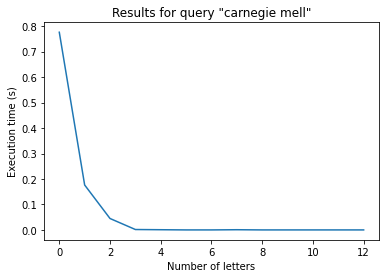

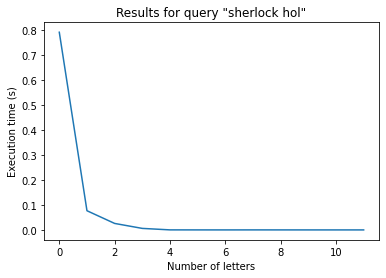

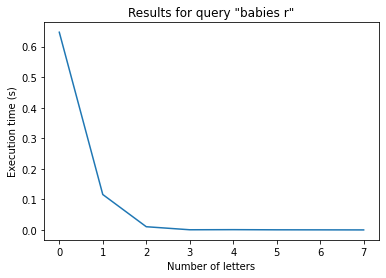

In [14]:
from matplotlib import pyplot as plt

queries = ["carnegie mell", 'sherlock hol', 'babies r']
for query in queries:
    result = avg_exec(query, aol_trie)
    plt.figure()
    plt.title(f'Results for query \"{query}\"')
    plt.plot(range(len(query)), result)
    plt.xlabel('Number of letters')
    plt.ylabel('Execution time (s)')
plt.show()

## 2.5. [+10] Add spellchecking to your suggest

Try to make your search results as close as possible. Compare top-5 results of each query with top-5 results for corrected.

In [119]:
inp_queries = ["inormation retrieval", "shelrock hol", "carnagie mell", "babis r", "Barrbara "]
inp_queries_corrected = ["information retrieval", "sherlock hol", "carnegie mell", "babies r", "Barbara "]

def complete_user_query_with_spellchecker(query, trie, top_k=5):
    #TODO: suggest top_k options for a user query
    # sort results by frequency, suggest first ranked urls if available
    filtered_query = list(filter(lambda x: x not in stops, query.split(' ')))
    spell = SpellChecker(language='en',  case_sensitive=False)
    misspelled = spell.unknown(filtered_query)
    for word in misspelled:
        idx = filtered_query.index(word)
        correction = spell.candidates(word).pop()
        if not len(correction) == 1:
            filtered_query[idx] = correction
    filtered_query = u" ".join(filtered_query)
    return complete_user_query(filtered_query, trie, top_k)


for q, qc in zip(inp_queries, inp_queries_corrected):
    assert  complete_user_query(qc, aol_trie, 5) == \
            complete_user_query_with_spellchecker(q, aol_trie, 5), "Assert {} and {} give different results".format(q, qc)

Suggestion: sherlock holmes, Frequency: 4, Suggested url: http://en.wikipedia.org
Suggestion: sherlock holmes society, Frequency: 2, Suggested url: http://www.sherlockian.net
Suggestion: sherlock holmes chronological order, Frequency: 2, Suggested url: http://www.geocities.com
Suggestion: sherlock holmes address, Frequency: 1,
Suggestion: sherlock holmes audiotapes, Frequency: 1,
Suggestion: sherlock holmes, Frequency: 4, Suggested url: http://en.wikipedia.org
Suggestion: sherlock holmes society, Frequency: 2, Suggested url: http://www.sherlockian.net
Suggestion: sherlock holmes chronological order, Frequency: 2, Suggested url: http://www.geocities.com
Suggestion: sherlock holmes address, Frequency: 1,
Suggestion: sherlock holmes audiotapes, Frequency: 1,
Suggestion: carnegie mellon, Frequency: 6, Suggested url: http://www.cmu.edu
Suggestion: carnegie mellon university, Frequency: 1, Suggested url: http://www.cmu.edu


AssertionError: Assert carnagie mell and carnegie mell give different results